In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb
!pip install tqdm, trange

# New Section

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import cv2
import random
from tqdm import tqdm
from PIL import Image
import albumentations as A
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
from tqdm import tqdm
import wandb
from torchvision.models import resnet50
from sklearn.metrics import f1_score, accuracy_score

# New Section

In [9]:
path ="/content/drive/MyDrive/competition/brief/train.csv"
# data = pd.read_csv(path)

In [10]:
# y = data.iloc[:, -1].values
# # check imbalance
# labels = np.unique(y)
# plt.bar(labels, np.bincount(y))

Load dataset

In [11]:
class LoadDataset():
  def __init__(self, train_dir, test_dir, height, width):
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.height = height
    self.width = width

  def reshape(self, data):
    return data.reshape(-1, 1, self.height, self.width).astype(np.float32)

  def split_data(self):
    train_df = pd.read_csv(self.train_dir)
    test_df = pd.read_csv(self.test_dir)

    train_df = train_df.drop("ID", axis = 1)
    test_df = test_df.drop("ID", axis = 1)

    x_train, x_val, y_train, y_val = train_test_split(train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values, test_size=0.2, random_state=42)

    x_train = self.reshape(x_train)
    x_val = self.reshape(x_val)
    x_test = self.reshape(test_df.values)

    return x_train, x_val, x_test, y_train, y_val

In [12]:
ld_dataset = LoadDataset("/content/drive/MyDrive/competition/brief/train.csv", "/content/drive/MyDrive/competition/brief/test.csv", 256, 256)

In [13]:
x_train, x_val, x_test, y_train, y_val = ld_dataset.split_data()

In [14]:
# Check train set
print("x_train shape", x_train.shape)
print("Get 1 item", x_train[0].shape) # (batch size, height, width) - gray


x_train shape (816, 1, 256, 256)
Get 1 item (1, 256, 256)


In [15]:
im =(x_train[0].reshape(256, 256))
im_plt = im / 255
# im has range [0,255]
# img_plt has range [0,1]
# the mean and denominator have a shape of (3,) so image has a shape of (height, width, channels)


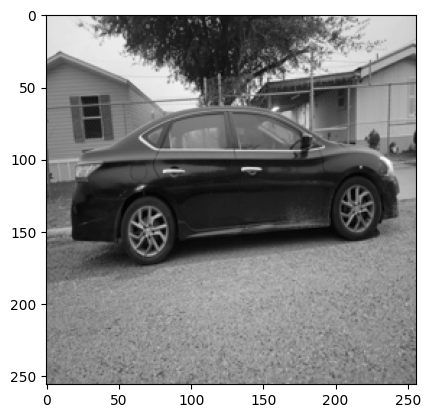

In [16]:
# show as matplotlib
plt.imshow(im_plt, cmap = "gray")

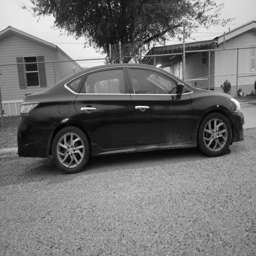

In [17]:
# cv2 show image to range [0,255]
# PIL, matplotlib show image to eang [0,1]
from google.colab.patches import cv2_imshow
cv2_imshow(im)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
path ="/content/drive/MyDrive/competition/brief/image1.jpg"
cv2.imwrite(path, im)

True

In [19]:
class DataGenerator(torch.utils.data.Dataset):
  def __init__(self, x, y, transforms = None):
    self.x = x
    self.y = y
    self.transform_image = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p = 0.8),
            A.Blur(),
            A.RandomBrightnessContrast(p = 0.8),

        ])

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    image = self.x[idx].reshape(256,256)
    label = self.y[idx]
    image = image / 255
    image = self.transform_image(image = image)["image"]
    return image, label




In [20]:
train_dataset = DataGenerator(x_train, y_train)
val_dataset = DataGenerator(x_val, y_val)


label 1


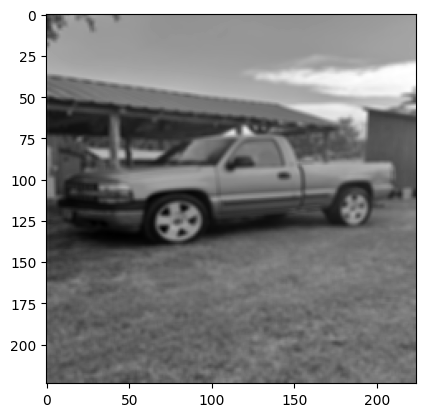

In [21]:
image, label = train_dataset.__getitem__(2)
print("label", label)
plt.imshow(image, cmap = "gray")

In [22]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 16, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 16, shuffle = True)

In [23]:
img_set, label_set = next(iter(train_dataloader))

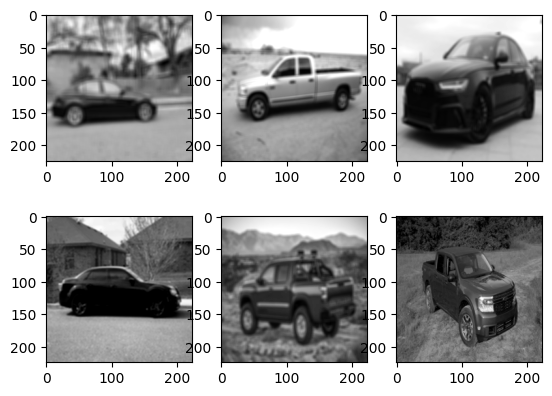

In [24]:
for idx, img in enumerate(img_set):
  if idx + 1 > 6:
    break
  plt.subplot(2,3,idx+1)
  plt.imshow(img, cmap = "gray")



# New Section

In [27]:
N_EPOCHS = 30
N_CLASSES = 2
LR = 0.0001
PATIENCE = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_PATH = "/content/drive/MyDrive/competition/brief/best_model_resnet50.pth"

In [28]:
class EarlyStopping:
    def __init__(self, tolerance=10, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [29]:
def train(n_classes, n_epochs, learning_rate, patience, save_path, device):
  wandb_log = wandb.init(project = "classifier competition")

  model = resnet50(weights = "IMAGENET1K_V1")
  # for param in model.parameters():
  #   param.requires_grad = False
  # set input size (B, 1, 224, 224)
  model.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, n_classes)
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
  early_stopping = EarlyStopping()
  for epoch in range(1, n_epochs+1):
    running_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    val_f1 = 0
    model.train()
    with tqdm(train_dataloader) as pbar:
      for batch in pbar:
        img, label = batch
        img = torch.unsqueeze(img, 1).to(device)
        label = label.to(device)
        label = label.long()

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)

      # correct = (output.argmax(dim = 1) == label).sum().item()
      # training_ac = ccorrect / len(label)
      # training_loss = loss.item()
        acc = accuracy_score(label.cpu(), output.argmax(dim = 1).cpu())

        running_loss += loss.item()
        train_acc += acc

        loss.backward()
        optimizer.step()

        pbar.set_description(f"Loss per Epoch: {epoch} / {N_EPOCHS}]")
        pbar.set_postfix(loss = loss.item(), accuracy = acc)

      # train loss, train accuracy per epoch
      train_loss_epoch = running_loss / len(train_dataloader)
      train_acc_epoch = train_acc / len(train_dataloader)
      wandb.log({"train_loss": train_loss_epoch, "train_accuracy": train_acc_epoch})

    model.eval()
    with torch.no_grad():
      with tqdm(val_dataloader) as pbar:

        for batch in pbar:
          img, label = batch
          img = torch.unsqueeze(img,1).to(device)
          label = label.to(device)
          label = label.long()

          output = model(img)
          loss = criterion(output, label)

          acc = accuracy_score(label.cpu(), output.argmax(dim = 1).cpu())
          f1 = f1_score(label.cpu(), output.argmax(dim = 1).cpu(), average = "macro")

          val_loss += loss.item()
          val_acc += acc
          val_f1 += f1

          pbar.set_description(f"Vaidation Loss per Epoch: {epoch} / {N_EPOCHS}]")
          pbar.set_postfix(loss = loss.item(), accuracy = acc, f1_score = f1)

      # validation loss, validation accuracy per epoch
      val_loss_epoch = val_loss / len(val_dataloader)
      val_acc_epoch = val_acc / len(val_dataloader)
      val_f1_epoch = val_f1 / len(val_dataloader)
      wandb.log({"val_loss": val_loss_epoch, "val_accuracy": val_acc_epoch, "val_f1": val_f1_epoch})

      # early stopping
      early_stopping(train_loss_epoch, val_loss_epoch)
      if early_stopping.early_stop:
        print(f"Early stopping at Epoch {epoch}")
        break


  # model.load_state_dict(torch.load(save_path))
  torch.save(model.state_dict(), save_path)
  wandb.finish()
  return model

# New Section

In [30]:
model = train(n_classes = N_CLASSES,
              n_epochs = N_EPOCHS,
              learning_rate = LR,
              patience = PATIENCE,
              save_path = SAVE_PATH,
              device = DEVICE)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]
Vaidation Loss per Epoch: 11 / 30]: 100%|██████████| 13/13 [00:00<00:00, 16.96it/s, accuracy=1, f1_score=1, loss=0.0674]


Early stopping at Epoch 11


train_accuracy,▁▆▇▇▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁▁
val_accuracy,▁▇▇▇▇▇▇▇▇█▇
val_f1,▁▇█▇▇▇▇▇▇█▆
val_loss,█▂▁▃▃▂▂▂▁▁▃
train_accuracy,0.98529
train_loss,0.03909
val_accuracy,0.9375
val_f1,0.90192
val_loss,0.24511


In [ ]:
# path = "/content/drive/MyDrive/competition/brief/model.pth"
# torch.save(model.state_dict(), path)